In this notebook, we analyze log data with a time range of 1 second (aggregated by an interval of 1 second).

- Data are imported from BigQuery, in the format of pandas.Dataframe.
- With data visualization tools, query count and status error count are chosen as features for model training. 
- Multiple machine learning models are applied here. 

### Setup environment

In [4]:
# !pip install --upgrade google-cloud-bigquery[pandas]
%load_ext google.cloud.bigquery
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from sklearn import mixture

import itertools
import tensorflow as tf
import json
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import LocalOutlierFactor

from sklearn.cluster import DBSCAN
from sklearn import metrics

import time
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

from sklearn.linear_model import LinearRegression

import sklearn.gaussian_process as gp

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

client = bigquery.Client()
sns.set(style="white")

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Import data

In [29]:
sql = """
SELECT
    service,
    querySum,
    checkSum,
    quotaSum,
    statusSum,
    queryPerInterval,
    queryDev,
    checkRatio,
    quotaRatio,
    statusRatio
FROM
    `shuainie-project1.dataflow_log_analytics.service_field_stats_table_1`
WHERE 
    service <> ''
"""
df = client.query(sql).to_dataframe()


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


Rename columns for self-explanatory feature names.

In [37]:
df = df.rename(columns={
    "querySum":    "queryCount", 
    "queryDev":    "queyDeviation",
    "checkSum":    "checkErrorCount",  
    "quotaSum":    "quotaErrorCount", 
    "statusSum":   "statusErrorCount",
    "checkRatio":  "checkErrorRatio", 
    "quotaRatio":  "quotaErrorRatio", 
    "statusRatio": "statusErrorRatio"})
df.head()

,service,queryCount,checkErrorCount,quotaErrorCount,statusErrorCount,queryPerInterval,queyDeviation,checkErrorRatio,quotaErrorRatio,statusErrorRatio
0,staging-documentai.sandbox.googleapis.com,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,dev-sixela-cloudsql.sandbox.googleapis.com,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,int-2-cloudsql.sandbox.googleapis.com,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,dev-restellis-cloudsql.sandbox.googleapis.com,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,dev-athenashi-cloudsql.sandbox.googleapis.com,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
ls = list(df.columns.values)   
ls.remove('service')

for c in ls:
    df[c] = df[c].astype(float)
    
print(df.dtypes)

service              object
queryCount          float64
checkErrorCount     float64
quotaErrorCount     float64
statusErrorCount    float64
queryPerInterval    float64
queyDeviation       float64
checkErrorRatio     float64
quotaErrorRatio     float64
statusErrorRatio    float64
dtype: object


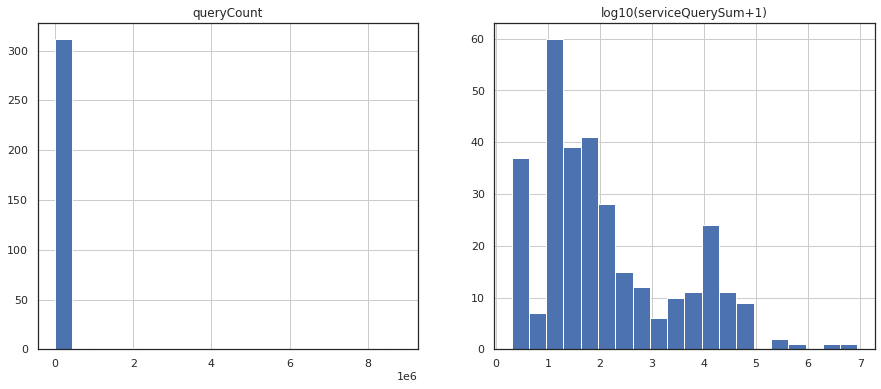

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(df['queryCount'], bins=20)
axs[0].set_title('queryCount')
axs[0].grid()

log10val = np.log10(df['queryCount']+1)
axs[1].hist(log10val, bins=20)
axs[1].set_title('log10(' + 'serviceQuerySum' + '+1)')
axs[1].grid()

plt.show()

In [40]:
ls = ['checkErrorCount', 'quotaErrorCount', 'statusErrorCount', 
      'checkErrorRatio', 'quotaErrorRatio', 'statusErrorRatio']

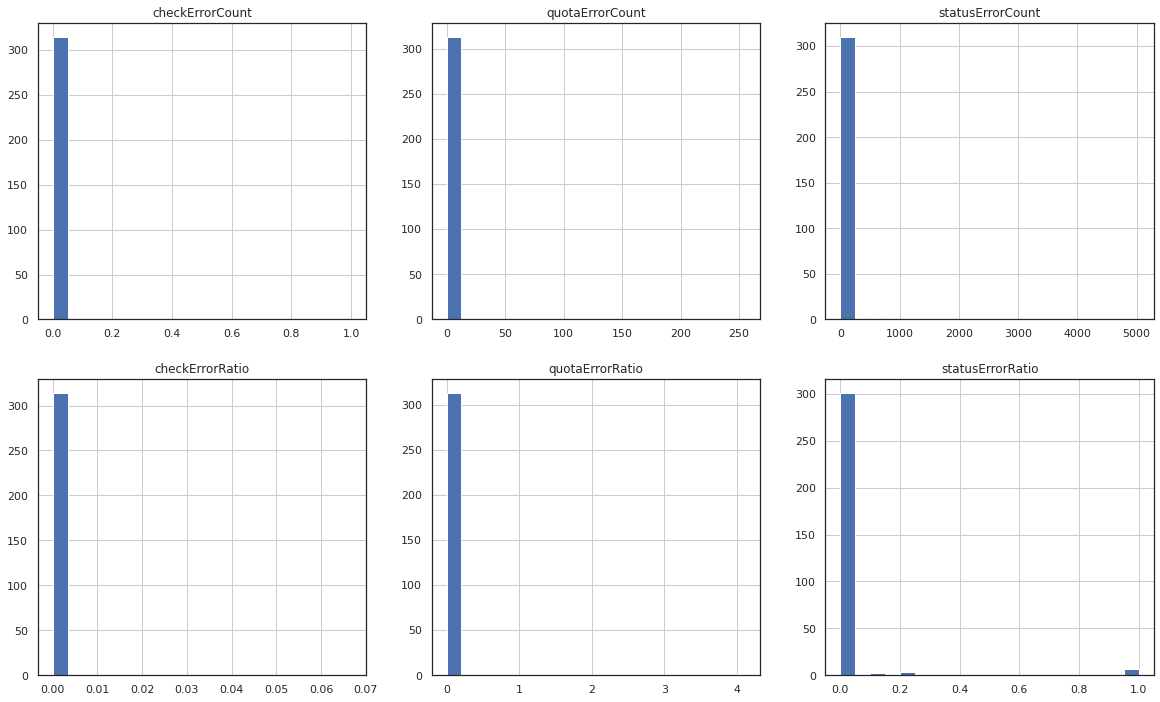

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for i in range(6):
    r, c = i // 3, i % 3
    axs[r,c].hist(df[ls[i]], bins=20)
    axs[r,c].set_title(ls[i])
    axs[r,c].grid()
plt.show()

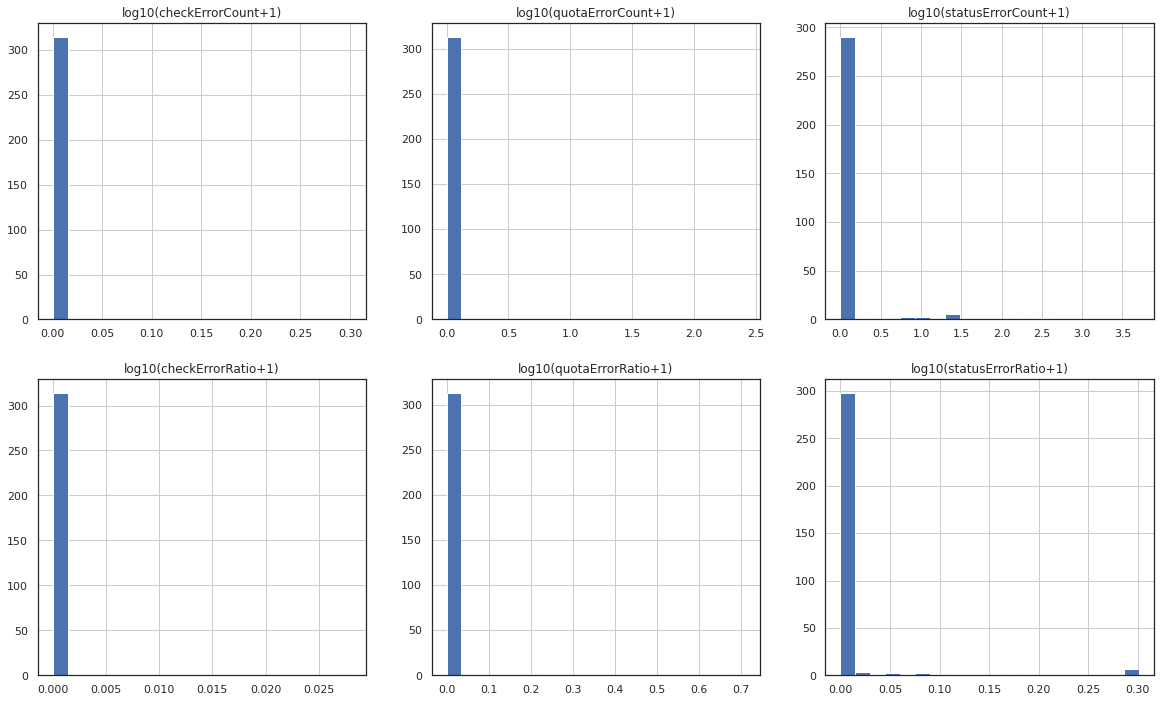

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for i in range(6):
    r, c = i // 3, i % 3
    log10val = np.log10(df[ls[i]]+1)
    axs[r,c].hist(log10val, bins=20)
    axs[r,c].set_title('log10(' + ls[i] + '+1)')
    axs[r,c].grid()
plt.show()


### Plot correlation matrix for features

In [43]:
ls = [
         'checkErrorCount',
         'statusErrorCount',
         'checkErrorRatio',
         'statusErrorRatio',
         'queryCount'
     ]

In [44]:
d = df[ls] #df[['queryPerInterval', 'checkRatio', 'quotaRatio', 'statusRatio']]
# normalized_df = (d - d.mean()) / d.std()
normalized_df = (d - d.min()) / (d.max() - d.min())
normalized_df.describe() # normalized_df.head()

,checkErrorCount,statusErrorCount,checkErrorRatio,statusErrorRatio,queryCount
count,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.003175,0.004759,0.003175,0.030208,0.004829
std,0.056344,0.057311,0.056344,0.159033,0.058030
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000001
50%,0.000000,0.000000,0.000000,0.000000,0.000006
75%,0.000000,0.000000,0.000000,0.000000,0.000088
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
cl = ['queryCount', 'checkErrorCount', 'checkErrorRatio', 'statusErrorCount', 'statusErrorRatio']
normalized_df = normalized_df[cl]

In [46]:
corr = normalized_df.corr()

<AxesSubplot:>

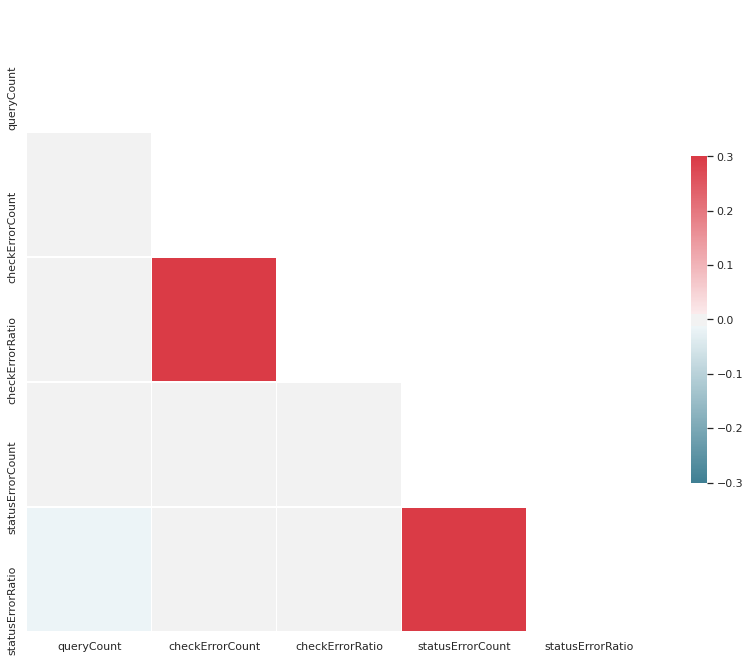

In [47]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [48]:
df[df.checkErrorCount != 0.0]

,service,queryCount,checkErrorCount,quotaErrorCount,statusErrorCount,queryPerInterval,queyDeviation,checkErrorRatio,quotaErrorRatio,statusErrorRatio
99,devel-language.sandbox.googleapis.com,15.0,1.0,0.0,0.0,15.0,0.0,0.066667,0.0,0.0


In [49]:
df[df.quotaErrorCount != 0.0]

,service,queryCount,checkErrorCount,quotaErrorCount,statusErrorCount,queryPerInterval,queyDeviation,checkErrorRatio,quotaErrorRatio,statusErrorRatio
116,sq-prober.googleprod.com,28.0,0.0,15.0,0.0,28.0,0.0,0.0,0.535714,0.000000
291,staging-compute.sandbox.googleapis.com,62.0,0.0,255.0,1.0,62.0,0.0,0.0,4.112903,0.016129


In [50]:
df[df.statusErrorCount != 0.0]

,service,queryCount,checkErrorCount,quotaErrorCount,statusErrorCount,queryPerInterval,queyDeviation,checkErrorRatio,quotaErrorRatio,statusErrorRatio
290,iap-pa.googleapis.com,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,1.000000
291,staging-compute.sandbox.googleapis.com,62.0,0.0,255.0,1.0,62.0,0.0,0.0,4.112903,0.016129
292,cloudml-perf-heavy-test.sandbox.googleapis.com,5.0,0.0,0.0,5.0,5.0,0.0,0.0,0.000000,1.000000
293,dev-bigquery-op.sandbox.googleapis.com,2175.0,0.0,0.0,5.0,2175.0,0.0,0.0,0.000000,0.002299
294,dev-remotebuildexecution.sandbox.googleapis.com,49.0,0.0,0.0,6.0,49.0,0.0,0.0,0.000000,0.122449
295,staging-ml.sandbox.googleapis.com,232.0,0.0,0.0,9.0,232.0,0.0,0.0,0.000000,0.038793
296,cloudml-dev.sandbox.googleapis.com,70.0,0.0,0.0,10.0,70.0,0.0,0.0,0.000000,0.142857
297,staging-monitoring.sandbox.googleapis.com,990.0,0.0,0.0,11.0,990.0,0.0,0.0,0.000000,0.011111
298,gaojian-healthcare.sandbox.googleapis.com,14.0,0.0,0.0,14.0,14.0,0.0,0.0,0.000000,1.000000
299,staging-recommendationengine.sandbox.googleapi...,73.0,0.0,0.0,15.0,73.0,0.0,0.0,0.000000,0.205479


### Selete features for model training

Since there is few data of check errors and quota errors, status errors will be used together with query count (small correlation) as model features.

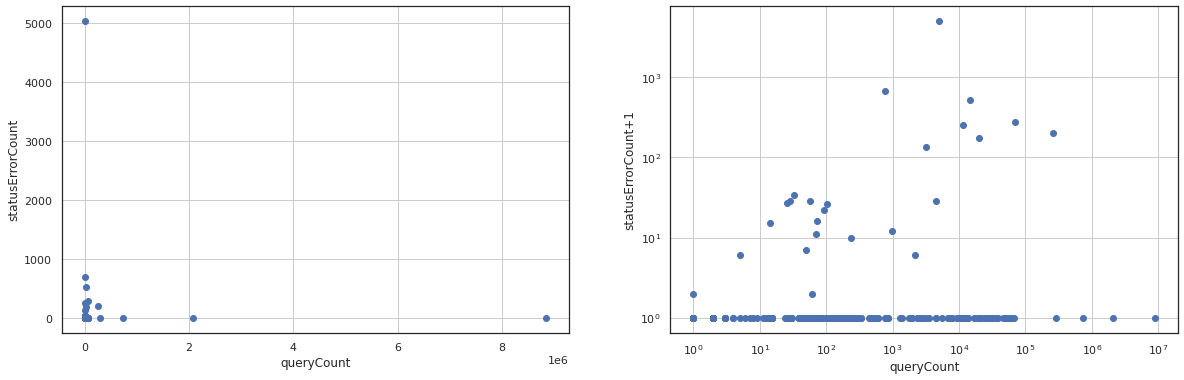

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

axs[0].scatter(df['queryCount'], df['statusErrorCount'])
axs[0].set_xlabel('queryCount')
axs[0].set_ylabel('statusErrorCount')
axs[0].grid()

axs[1].scatter(df['queryCount'], df['statusErrorCount']+1)
axs[1].set_xlabel('queryCount')
axs[1].set_ylabel('statusErrorCount+1')
axs[1].set_xscale('log') #
axs[1].set_yscale('log') #
axs[1].grid()

plt.show()

In [52]:
a = np.log10(df['queryCount']) #
a = a.to_numpy().reshape(a.shape[0],1)

b = np.log10(df['statusErrorCount']+1) #
b = b.to_numpy().reshape(b.shape[0],1)

X = np.concatenate((a, b), axis=1)
X.shape

(315, 2)

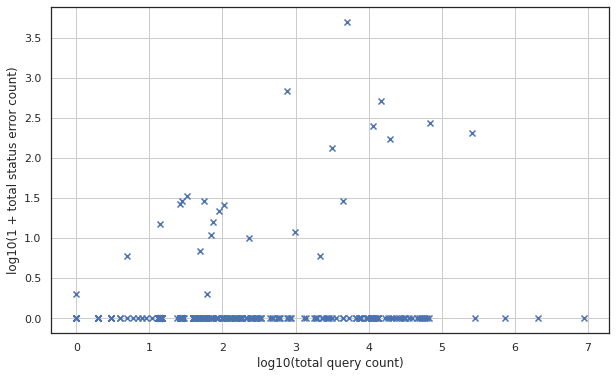

In [53]:
xlabel, ylabel = "log10(total query count)", "log10(1 + total status error count)"

plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker="x");
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid()

A manual criterion is applied to determine anomalies:   
- log10(query count) > 2.5, and
- log10(1 + total status error count) / log10(query count) > 0.7   
   
We can define some define set for modeling training.

In [55]:
# X_train
X_train = X
# y_train
y_train = [1 if q > 2.5 and s/q > 0.7 else 0 for q,s in X_train.tolist()] 
y_train = np.asarray(y_train)
print(X_train.shape, y_train.shape)

(315, 2) (315,)


In [56]:
# na: not anomalous (normal)
# a:  anomalous

X_train_na = X_train[y_train != 1]
y_train_na = y_train[y_train != 1]
print('normal', X_train_na.shape, y_train_na.shape)

X_train_a = X_train[y_train == 1]
y_train_a = y_train[y_train == 1]
print('anomalous', X_train_a.shape, y_train_a.shape)

normal (313, 2) (313,)
anomalous (2, 2) (2,)


In [57]:
# n0: total status error is not 0

X_train_n0 = X_train[X_train[:,1] != 0.0]
y_train_n0 = y_train[X_train[:,1] != 0.0]
print(X_train_n0.shape, y_train_n0.shape)

(25, 2) (25,)


In [58]:
# n0_na: total status error is not 0, not anomalous

X_train_n0_na = X_train_n0[y_train_n0 != 1]
y_train_n0_na = y_train_n0[y_train_n0 != 1]
print(X_train_n0_na.shape, y_train_n0_na.shape)

(23, 2) (23,)


### Gaussian mixture model

In [59]:
# https://towardsdatascience.com/understanding-anomaly-detection-in-python-using-gaussian-mixture-model-e26e5d06094b
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    # print(mu, var)
    return mu,var

def multivariateGaussian(X, mu, sigma):
    k = len(mu)
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p

mu, sigma = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma)

In [60]:
print(mu, sigma)
# print(p)

[2.07619399 0.12509313] [1.85082166 0.23393836]


In [61]:
# threshold
epsilon = 3e-4

In the following figure, data points with likelihoods lower than epsilon are circled by red.

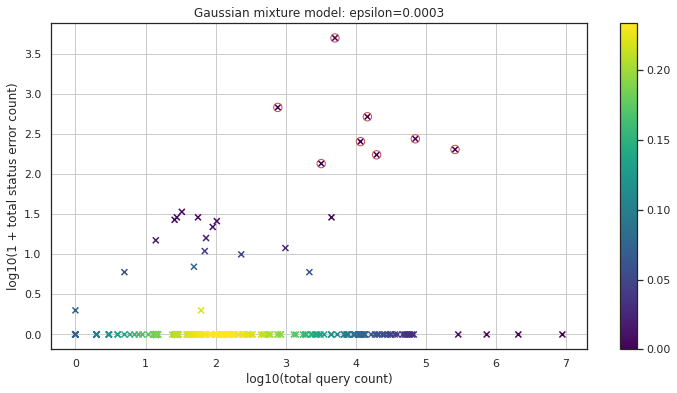

In [62]:
# https://towardsdatascience.com/understanding-anomaly-detection-in-python-using-gaussian-mixture-model-e26e5d06094b
plt.figure(figsize=(12,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid()

# cycle outliers
outliers = np.nonzero(p < epsilon)[0]
plt.scatter(X[outliers,0], X[outliers,1], marker="o", facecolor="none", edgecolor="r", s=70);
plt.title("Gaussian mixture model: epsilon={}".format(epsilon))

plt.show()

### Gaussian mixture model (another one)

In [28]:
def applyGmm(data, n_components, covariance_type, xrange=[-1., 10.], yrange=[-1., 5.]):
    # https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
    clf = mixture.GaussianMixture(n_components=n_components, 
                                  covariance_type=covariance_type)
    clf.fit(data)

    for i in range(n_components):
        print('component ' + str(i))
        print('weight: ' + str(clf.weights_[i]))
        print('mean: ' + str(clf.means_[i]))
        print('covariance: ' + str(clf.covariances_[i]))
        print('')
        
    y_pred = clf.predict(data)

    # https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
    # display predicted scores by the model as a contour plot
    plt.figure(figsize=(12,6))
    x = np.linspace(xrange[0], xrange[1], num=100)
    y = np.linspace(yrange[0], yrange[1],  num=1000)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1e3),
                     levels=np.logspace(0, 3, 100))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    for i in range(n_components):
        f = y_pred == i
        plt.scatter(data[f, 0], data[f, 1], marker="*")

    plt.title('Negative log-likelihood predicted by a GMM: n_components = %d' % n_components)
    plt.axis('tight')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

component 0
weight: 1.0
mean: [2.07619399 0.12509313]
covariance: [[1.85082266 0.1229445 ]
 [0.1229445  0.23393936]]



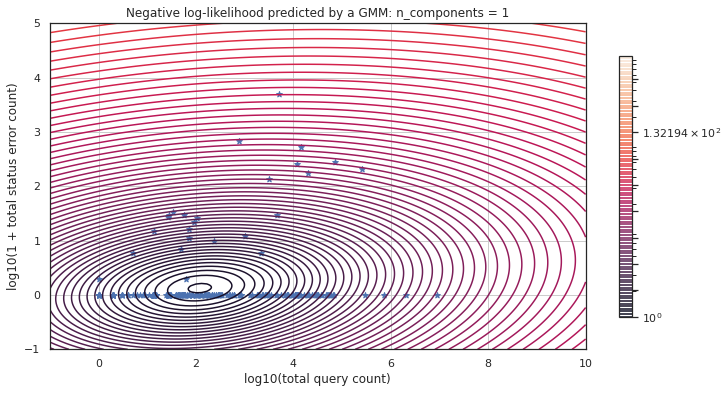

In [29]:
applyGmm(data=X_train, n_components=1, covariance_type='full')

component 0
weight: 0.9206190073104583
mean: [2.03320307 0.        ]
covariance: [[1.83232232e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-06]]

component 1
weight: 0.07938099268954103
mean: [2.57478006 1.57585743]
covariance: [[1.79535715 0.76308957]
 [0.76308957 0.6608357 ]]



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Log scale: values of z <= 0 have been masked


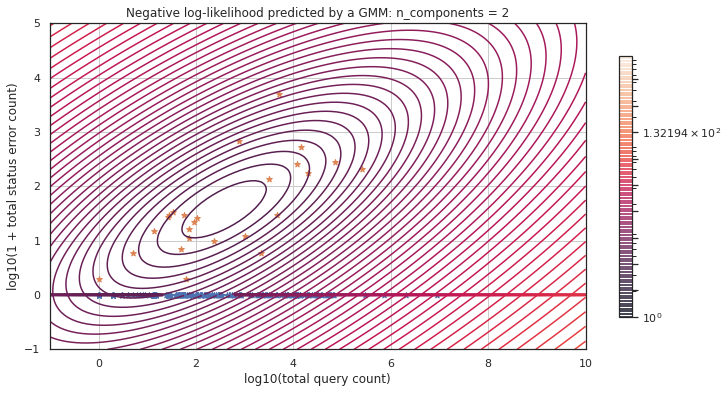

In [30]:
applyGmm(data=X_train, n_components=2, covariance_type='full')

component 0
weight: 0.03460753081315021
mean: [1.43315973 1.16628319]
covariance: [[0.33572332 0.15391329]
 [0.15391329 0.12740739]]

component 1
weight: 0.044763919269980204
mean: [3.45782255 1.89284019]
covariance: [[1.13600066 0.59211773]
 [0.59211773 0.84267866]]

component 2
weight: 0.9206285499168693
mean: [2.03318719 0.        ]
covariance: [[1.83232399e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-06]]



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Log scale: values of z <= 0 have been masked


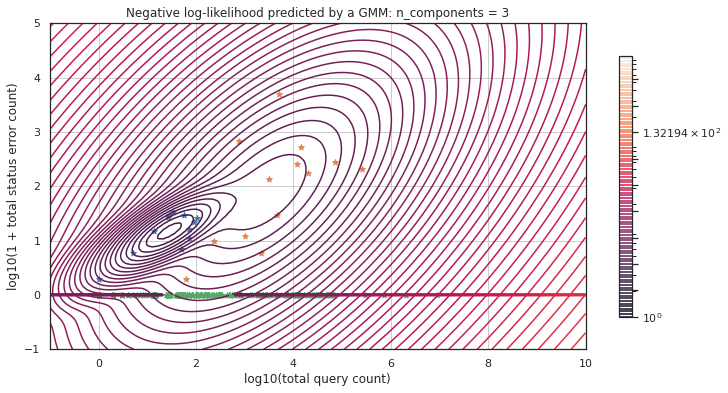

In [31]:
applyGmm(data=X_train, n_components=3, covariance_type='full')

- Note that in cases with 2 or 3 Gaussian components, there is 1 componet looks like a line lying along the x-axis. Data points assigned to this component has varying total query count but zero total status error count. 
- A data point is counted anomaly if its likelihood to be generated by the mixture is low
- Post-processing may be needed for specific business problems. For example, the blue point near (0, 0), although having a low likelihood, should not be considered as an anomaly as it has low query count and check error count.

### DBSCAN

In [87]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
# Compute DBSCAN
db = DBSCAN(eps=0.6, min_samples=3).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [88]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [89]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y_train, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y_train, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train, labels))

Estimated number of clusters: 3
Estimated number of noise points: 7
Homogeneity: 0.654
Completeness: 0.104
V-measure: 0.180
Adjusted Rand Index: 0.220
Adjusted Mutual Information: 0.173
Silhouette Coefficient: 0.445


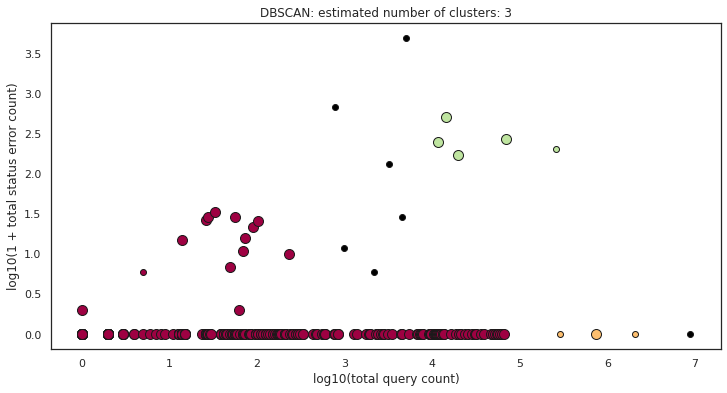

In [114]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
plt.figure(figsize=(12,6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.title('DBSCAN: estimated number of clusters: %d' % n_clusters_)
plt.show()

### K-Means

In [91]:
n_clusters = 4
colors = ['#0000FF', '#4EACC5', '#FF9C34', '#4E9A06']

In [92]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py
# K-Means
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
t0 = time.time()
k_means.fit(X_train)
t_batch = time.time() - t0

In [93]:
# mini batch K-Means
mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=30,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X_train)
t_mini_batch = time.time() - t0

In [94]:
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X_train, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X_train, mbk_means_cluster_centers)

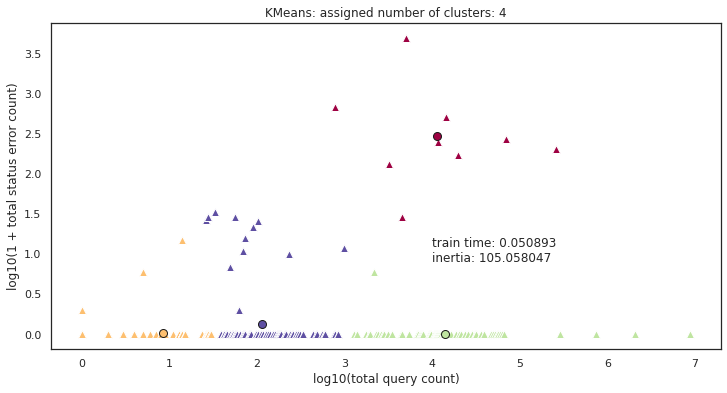

In [115]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py
plt.figure(figsize=(12,6))
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X_train[my_members, 0], X_train[my_members, 1], 'w',
            markerfacecolor=col, marker='^', markersize=8)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=8)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('KMeans: assigned number of clusters: %d' % n_clusters)
plt.text(4, 0.9, 'train time: %f\ninertia: %f' % (t_batch, k_means.inertia_))
plt.show()

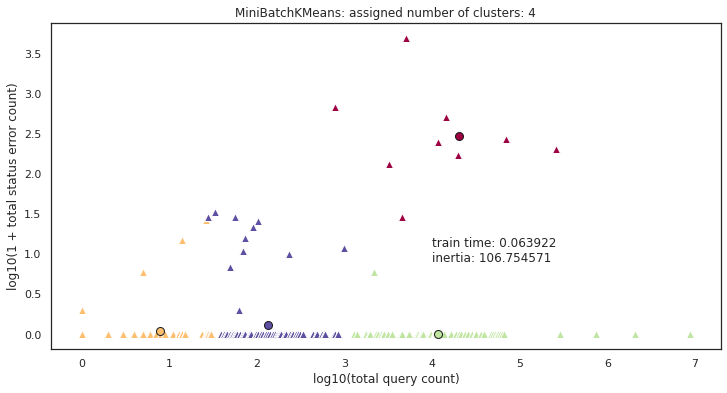

In [116]:
plt.figure(figsize=(12,6))
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    plt.plot(X_train[my_members, 0], X_train[my_members, 1], 'w',
            markerfacecolor=col, marker='^', markersize=8)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=8)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('MiniBatchKMeans: assigned number of clusters: %d' % n_clusters)
plt.text(4, 0.9, 'train time: %f\ninertia: %f' % (t_mini_batch, mbk.inertia_))
plt.show()

### Linear regression

In [117]:
def applyLR(data, label=None):
    X, y = data[:,0].reshape(-1, 1), data[:,1].reshape(-1, 1)
    
    # https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
    reg = LinearRegression().fit(X, y)
    s = reg.score(X, y)
    
    y_pred = reg.predict(X)
    
    plt.figure(figsize=(12,6))
    plt.scatter(X, y,  color='black')
    plt.plot(X, y_pred, color='blue', linewidth=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Linear regression: score = %f' % s)
    

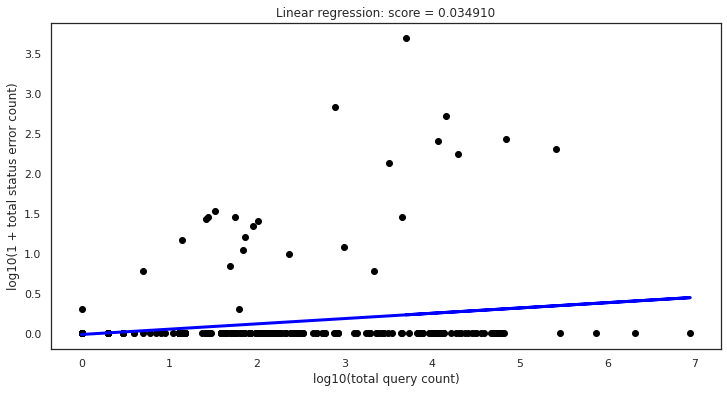

In [118]:
applyLR(data=X_train)

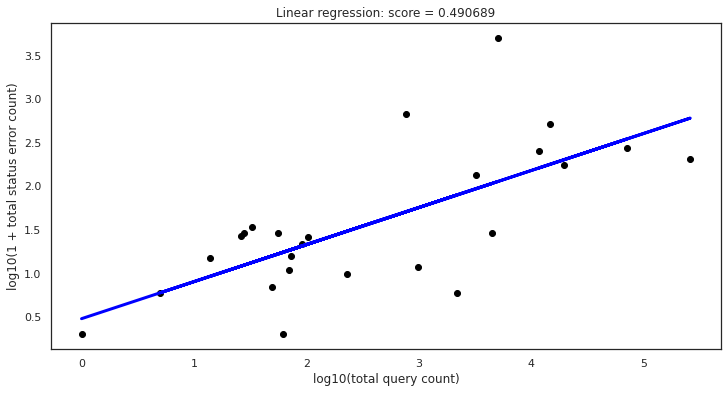

In [119]:
applyLR(data=X_train_n0)

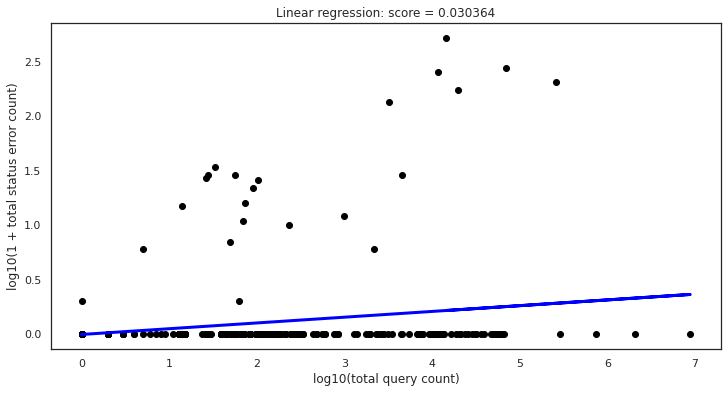

In [120]:
applyLR(data=X_train_na)

### Gaussian process regression (proper usage?)

In [122]:
# https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [123]:
model.fit(X_train, y_train)
params = model.kernel_.get_params()

In [124]:
threshold = 1e-2

In [125]:
y_pred, std = model.predict(X_train, return_std=True)
mse = ((y_pred-y_train)**2).mean() # MSE

y_pred = np.array([1 if abs(e) > threshold else 0 for e in y_pred-y_train])

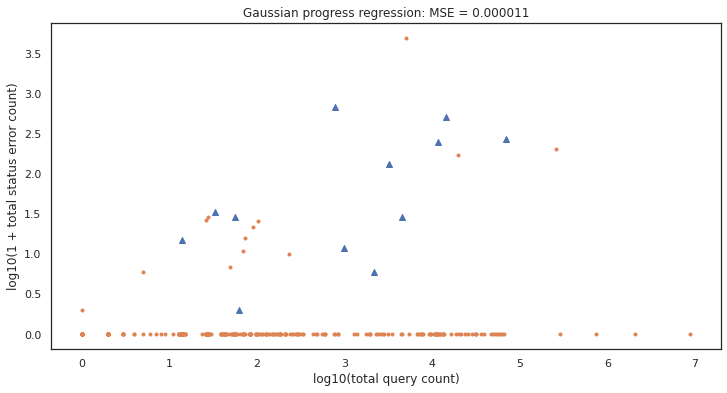

In [126]:
anomalous_pred = y_pred == 1
normal_pred = y_pred == 0

plt.figure(figsize=(12,6))
plt.scatter(X_train[anomalous_pred, 0], X_train[anomalous_pred, 1], marker='^')
plt.scatter(X_train[normal_pred, 0], X_train[normal_pred, 1], marker='.')
plt.title('Gaussian progress regression: MSE = %f' % mse)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

In [131]:
def applyGPR(data2d_normal, data2d_anomalous):
    # https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319
    kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF(10.0, (1e-2, 1e2))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    
    X, y = data2d_normal[:,0].reshape(-1,1), data2d_normal[:, 1].reshape(-1,1)
    X_a, y_a = data2d_anomalous[:,0].reshape(-1,1), data2d_anomalous[:, 1].reshape(-1,1)
    
    model.fit(X, y)
    params = model.kernel_.get_params()
    y_pred, sigma = model.predict(X, return_std=True)
    mse = ((y_pred-y)**2).mean()
    
    x = np.atleast_2d(np.linspace(0, 7, 100)).T
    y_pred, sigma = model.predict(x, return_std=True)
    
    y_a_pred, std_a = model.predict(X_a, return_std=True)
    
    plt.figure(figsize=(12,6))
    
    plt.plot(X, y, 'r.', markersize=10, label='Observations')
    plt.plot(x, y_pred, 'r-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.8, fc='b', ec='None', label='95% confidence interval')
    
    plt.scatter(X_a, y_a, color='g', marker='^', label='Observations')
    plt.scatter(X_a, y_a_pred, color='g', marker='*', label='Prediction')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('train normal data: MSE = %f' % mse)
    plt.show()

The model is trained given 3 data sets.

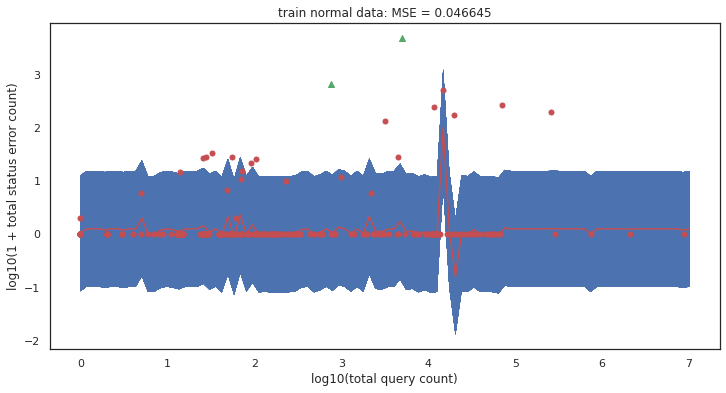

In [135]:
applyGPR(data2d_normal=X_train_na, data2d_anomalous=X_train_a)

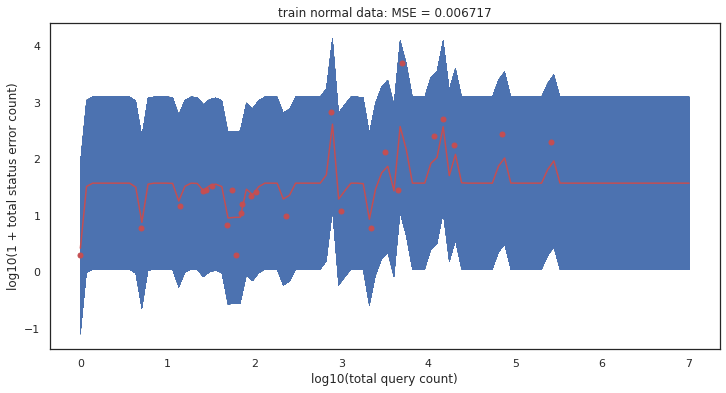

In [136]:
applyGPR(data2d_normal=X_train_n0, data2d_anomalous=X_train_a)

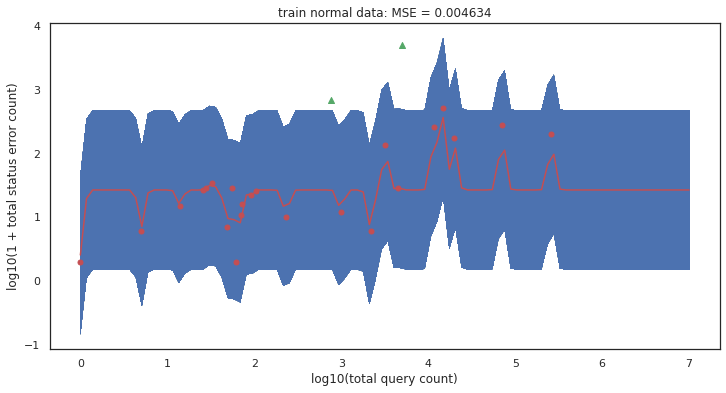

In [137]:
applyGPR(data2d_normal=X_train_n0_na, data2d_anomalous=X_train_a)